# SIR model: inverse problem
## A PINN approach

In this notebook, we will solve the inverse problem of the SIR model using a Physics-Informed Neural Network (PINN). The goal is to estimate the infection rate $\beta$ from the observed data of the infected population. To do this, we will train a PINN model using a **joint training** approach, where we compute the residuals of the SIR ODE and the initial conditions and the data loss simultaneously.

The SIR model is governed by the following set of ordinary differential equations (ODEs):

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display, HTML
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_percentage_error

# if torch.backends.mps.is_available():
#   torch.set_default_device("mps")

figures_dir = "figures"
data_dir = "data"
sns.set_theme(style="darkgrid")

timestamp = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

### Data Generation

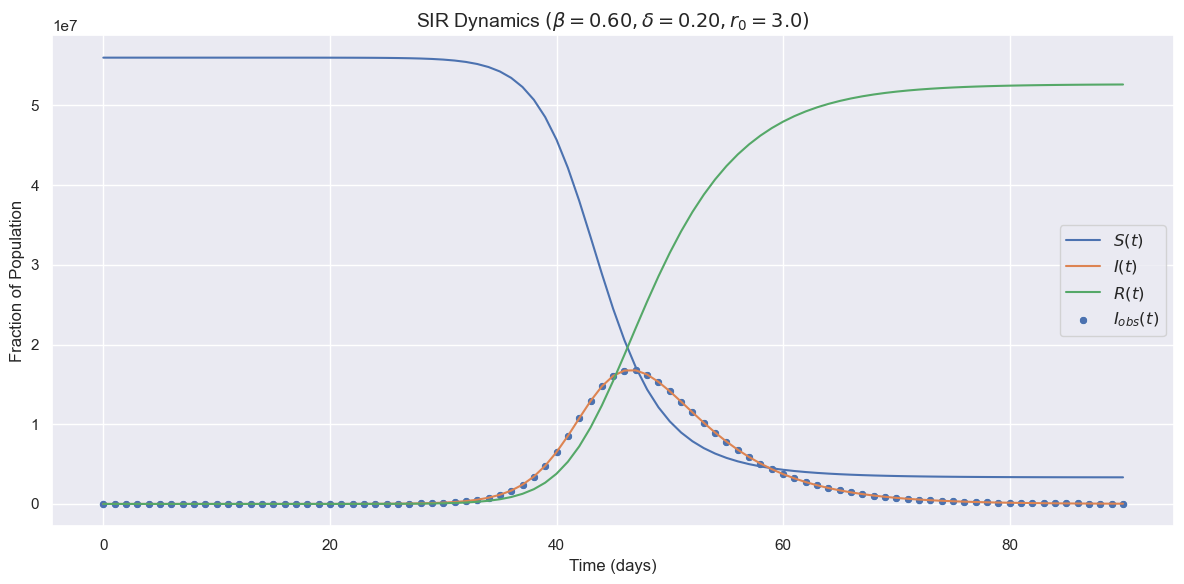

In [2]:
# True SIR parameters for data generation
N = 56e6  # Total population (for scaling)
delta = 1 / 5  # Recovery rate (per day)
r0 = 3.0  # Basic reproduction number
beta_true = delta * r0  # Infection rate (per day)


def sir(x, _, d, b):
  s, i, r = x
  l = b * i / N
  ds_dt = -l * s
  di_dt = l * s - d * i
  dr_dt = d * i
  return np.array([ds_dt, di_dt, dr_dt])


# Initial conditions (actual population counts)
S0 = N - 1
I0 = 1
R0 = 0

# Time domain for simulation
t_start, t_end = 0, 90  # days
t = np.linspace(t_start, t_end, t_end - t_start + 1)

solution = odeint(sir, [S0, I0, R0], t, args=(delta, beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

i_obs = np.random.poisson(i_true)

plt.subplots(figsize=(12, 6))

sns.lineplot(x=t, y=s_true, label=r"$S(t)$")
sns.lineplot(x=t, y=i_true, label=r"$I(t)$")
sns.lineplot(x=t, y=r_true, label=r"$R(t)$")
sns.scatterplot(x=t, y=i_obs, label=r"$I_{obs}(t)$")

plt.title(
  f"SIR Dynamics $\\left(\\beta={beta_true:.2f}, \\delta={delta:.2f}, r_0={r0}\\right)$",
  fontsize=14
)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Fraction of Population", fontsize=12)

plt.legend(fontsize=12, loc="center right")

plt.tight_layout()

plt.savefig(f"{figures_dir}/synthetic_data.png", dpi=300)

### Data Preprocessing

In [3]:
s_true = s_true / N
i_true = i_true / N
r_true = r_true / N

ic = np.array([S0, I0, R0]) / N
i_obs = i_obs / N

# Convert observation data to torch tensors for training
t0_tensor = torch.tensor([[0.0]], dtype=torch.float32)
ic_tensor = torch.tensor(ic, dtype=torch.float32).reshape(1, -1)

t_obs_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
i_obs_tensor = torch.tensor(i_obs, dtype=torch.float32).reshape(-1, 1)

### Model Definition

In [4]:
class Square(nn.Module):
  """
  A module that squares its input element-wise.
  Useful as a final activation to enforce non-negativity.
  """

  @staticmethod
  def forward(x):
    return torch.square(x)


def create_fnn(layers_dimensions, activation, output_activation):
  layers_modules = []
  for i in range(len(layers_dimensions) - 1):
    layers_modules.append(
      nn.Linear(layers_dimensions[i], layers_dimensions[i + 1])
    )
    if i < len(layers_dimensions) - 2:
      layers_modules.append(activation)
  layers_modules.append(output_activation)

  net = nn.Sequential(*layers_modules)

  # Initialize weights and biases (Xavier initialization for weights, zeros for biases)
  for m in net:
    if isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)

  return net


class PINN(nn.Module):
  def __init__(
      self,
      given_N,
      given_delta,
      given_initial_beta,
      layers_dimensions,
      activation,
      output_activation,
  ):
    if layers_dimensions is None:
      layers_dimensions = [1] + [50] * 3 + [1]

    super(PINN, self).__init__()
    self.net_S = create_fnn(layers_dimensions, activation, output_activation)
    self.net_I = create_fnn(layers_dimensions, activation, output_activation)

    self.beta = torch.nn.Parameter(
      torch.tensor(given_initial_beta, dtype=torch.float32)
    )
    self.delta = given_delta
    self.N = torch.tensor(given_N, dtype=torch.float32)

  def forward(self, x):
    S = self.net_S(x)
    I = self.net_I(x)
    R = self.N.to(x.device) - S - I

    return torch.cat([S, I, R], dim=1)

  def compute_pde_residuals(self, x):
    """Compute residuals of SIR ODE at times t.
    Returns tensors of the same shape as t."""
    x.requires_grad_(True)
    S = self.net_S(x)
    I = self.net_I(x)

    dS_dt = torch.autograd.grad(
      S, x, grad_outputs=torch.ones_like(S), create_graph=True
    )[0]
    dI_dt = torch.autograd.grad(
      I, x, grad_outputs=torch.ones_like(I), create_graph=True
    )[0]

    res_S = dS_dt + self.beta * S * I
    res_I = dI_dt - self.beta * S * I + self.delta * I
    return res_S, res_I

### Hyperparameters

In [5]:
use_saved_model = True  # whether to explicitly trigger a new training

iterations = 5000 * 60  # number of optimizer steps
sampling_points = 100  # number of points to sample each step for computing losses
dataset_size = 6000  # number of points in the dataset used throughout the training
batch_size = 100  # number of points from the dataset to use in each optimizer step
# batches_per_epoch = ⌈dataset_size / batch_size⌉
epochs = 5000

learning_rate = 1e-3  # optimizer learning rate
patience = 200  # number of steps without loss improvement to stop training
log_interval = 100  # for debug purpose, number of epochs between logging training info

weights_update_rate = 100  # number of epoch between updates of the weighted sum's weights
initial_weight_pde = 0.1  # initial weight for PDE loss
initial_weight_ic = 0.45  # initial weight for IC loss
# initial_weight_data = 1 - initial_weight_pde - initial_weight_ic
smoothing_factor = 0.9  # smoothing factor for weights updates

layers = [1] + [50] * 4 + [1]  # neural network architecture
activation_fn = nn.Tanh()  # activation function for hidden layers
output_activation_fn = Square()  # activation function for output layer

loss_fn = nn.MSELoss()  # selected loss function: Mean Squared Error

initial_beta = 0.5  # initial value for beta parameter

### Training

In [6]:
model = PINN(
  given_N=1.0,
  given_delta=delta,
  given_initial_beta=initial_beta,
  layers_dimensions=layers,
  activation=activation_fn,
  output_activation=output_activation_fn
)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  adam_optimizer,
  mode='min',
  factor=0.5,  # Less aggressive reduction (default is 0.1)
  patience=100,  # Wait longer before reducing
  threshold=0.01,  # Higher threshold to prevent premature reduction
  min_lr=1e-6
)

loss_df = pd.DataFrame(
  columns=["L_pde", "L_ic", "L_data", "L_total"]
)
evolution_df = pd.DataFrame(
  columns=["beta", "params", "lr", "re_s", "re_i"]
)

In [7]:
def loss_pde(x):
  res_S, res_I = model.compute_pde_residuals(x)
  loss_res_S = loss_fn(res_S, torch.zeros_like(res_S))
  loss_res_I = loss_fn(res_I, torch.zeros_like(res_I))
  return loss_res_S + loss_res_I


def loss_ic():
  ic_pred = model(t0_tensor)
  return loss_fn(ic_pred, ic_tensor)


def loss_data():
  I = model(t_obs_tensor)[:, 1].reshape(-1, 1)
  return loss_fn(I, i_obs_tensor)

In [8]:
l_pde_history = []
l_ic_history = []
l_data_history = []
l_total_history = []
beta_evolution = []
params_evolution = []
lr_evolution = []
re_s_history = []
re_i_history = []


def re(pred, true):
  """Calculate Relative Error between predicted and true values."""
  return np.linalg.norm(true - pred, 2) / np.linalg.norm(true, 2)


def compute_full_dataset_loss(t_tensor):
  """Compute loss on full dataset"""
  t_eval = t_tensor.clone().detach().requires_grad_(True)

  l_pde_full = loss_pde(t_eval)
  l_ic_full = loss_ic()
  l_data_full = loss_data()

  l_total_full = l_pde_full + l_ic_full + l_data_full

  l_pde_history.append(l_pde_full.item())
  l_ic_history.append(l_ic_full.item())
  l_data_history.append(l_data_full.item())
  l_total_history.append(l_total_full.item())

  return l_total_full


def compute_param_change(old_params, new_params):
  """Compute L2 norm of parameter changes between epochs"""
  param_diff_squared_sum = 0.0

  for old_p, new_p in zip(old_params, new_params):
    param_diff_squared_sum += torch.sum((old_p - new_p) ** 2).item()

  return np.sqrt(param_diff_squared_sum)


def train():
  best_loss = np.inf
  no_improvement = 0

  # Create dataset of random samples
  t_dataset = np.expm1(
    np.random.uniform(
      np.log1p(t_start),
      np.log1p(t_end),
      dataset_size
    )
  )
  t_dataset = torch.tensor(t_dataset, dtype=torch.float32).reshape(-1, 1)

  # Combined dataset (observations + random samples)
  t_tensor = torch.cat([t_obs_tensor, t_dataset], dim=0)

  # Create mask to identify observation points
  is_obs = torch.zeros(t_tensor.shape[0], dtype=torch.bool)
  is_obs[:t_obs_tensor.shape[0]] = True

  batches_per_epoch = int(np.ceil(t_tensor.shape[0] / batch_size))

  old_params = [p.clone().detach() for p in model.parameters()]

  for epoch in range(1, epochs + 1):
    perm = torch.randperm(t_tensor.shape[0])
    t_tensor_shuffled = t_tensor[perm]
    is_obs_shuffled = is_obs[perm]

    obs_mapping = {}
    for i, idx in enumerate(perm.tolist()):
      if idx < t_obs_tensor.shape[0]:
        obs_mapping[i] = idx

    for batch in range(batches_per_epoch):
      adam_optimizer.zero_grad()

      batch_start = batch * batch_size
      batch_end = min(batch_start + batch_size, t_tensor.shape[0])
      t_batch = t_tensor_shuffled[batch_start:batch_end]
      is_obs_batch = is_obs_shuffled[batch_start:batch_end]

      L_pde = loss_pde(t_batch)
      L_ic = loss_ic()
      L_data = torch.tensor(0.0, requires_grad=True)

      if is_obs_batch.any():
        obs_points_in_batch = t_batch[is_obs_batch]
        outputs = model(obs_points_in_batch)
        predicted_I = outputs[:, 1].reshape(-1, 1)

        batch_obs_indices = [
          obs_mapping[i + batch_start]
          for i in range(len(is_obs_batch))
          if is_obs_batch[i]
        ]
        true_I = i_obs_tensor[batch_obs_indices]

        L_data = loss_fn(predicted_I, true_I)

      loss = L_pde + L_ic + L_data
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      adam_optimizer.step()

    l_total = compute_full_dataset_loss(t_tensor)

    scheduler.step(l_total)

    # compute parameters changes
    new_params = [p.clone().detach() for p in model.parameters()]
    param_change = compute_param_change(old_params, new_params)
    old_params = new_params
    params_evolution.append(param_change)

    beta_evolution.append(model.beta.item())
    lr_evolution.append(adam_optimizer.param_groups[0]['lr'])

    # compute re with s_true, i_true, r_true

    t_pred = t_obs_tensor.cpu().detach().numpy().flatten()
    s_pred, i_pred, _ = model(t_obs_tensor).cpu().detach().numpy().T

    re_s_history.append(re(s_pred, s_true))
    re_i_history.append(re(i_pred, i_true))

    if l_total < best_loss:
      best_loss = l_total
      no_improvement = 0
    else:
      no_improvement += 1

    if epoch % log_interval == 0:
      print(
        f"[{epoch:<{len(str(epochs))}}/{epochs}]: "
        f"β = {beta_evolution[-1]:.4f} "
        f"| Loss = {l_total_history[-1]:.2e} "
        f"| Param Δ = {params_evolution[-1]:.2e} "
        f"| lr = {lr_evolution[-1]:.2e} "
        f"| no improvement = {no_improvement}"
      )

    if no_improvement >= patience:
      print(f"[{epoch}/{epochs}]: Patience reached, stopping training.")
      break

  save_training()


def save_training():
  if not l_total_history:
    return

  loss_df['L_pde'] = l_pde_history
  loss_df['L_ic'] = l_ic_history
  loss_df['L_data'] = l_data_history
  loss_df['L_total'] = l_total_history
  evolution_df['beta'] = beta_evolution
  evolution_df['params'] = params_evolution
  evolution_df['lr'] = lr_evolution
  evolution_df["re_s"] = re_s_history
  evolution_df["re_i"] = re_i_history

  loss_df.to_csv(f"{data_dir}/loss_history.csv", float_format='%.6e')
  evolution_df.to_csv(f"{data_dir}/evolutions.csv", float_format='%.6e')

  torch.save(model.state_dict(), f"{data_dir}/model.pth")

In [9]:
if use_saved_model:
  try:
    state_dict = torch.load(f"{data_dir}/model.pth", weights_only=True)
    model.load_state_dict(state_dict)
    loss_df = pd.read_csv(f"{data_dir}/loss_history.csv")
    evolution_df = pd.read_csv(f"{data_dir}/evolutions.csv")
  except FileNotFoundError:
    train()
else:
  train()

In [10]:
# save_training()
t_pred = t_obs_tensor.cpu().detach().numpy().flatten()
s_pred, i_pred, r_pred = model(t_obs_tensor).cpu().detach().numpy().T
beta_pred = model.beta.item()

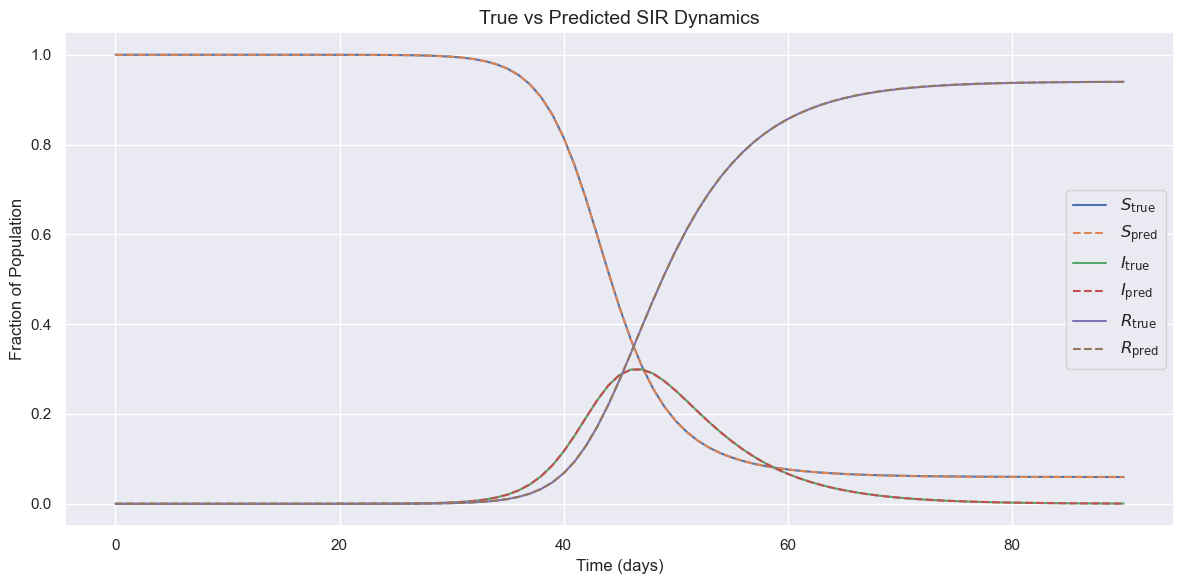

In [11]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=t_pred, y=s_true, label="$S_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=s_pred, label="$S_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=i_true, label="$I_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=i_pred, label="$I_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=r_true, label="$R_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=r_pred, label="$R_{\mathrm{pred}}$", linestyle="--")

plt.title('True vs Predicted SIR Dynamics', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Fraction of Population', fontsize=12)

plt.legend(fontsize=12, loc='center right')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f"{figures_dir}/sir_predictions_{timestamp}.png", dpi=300)

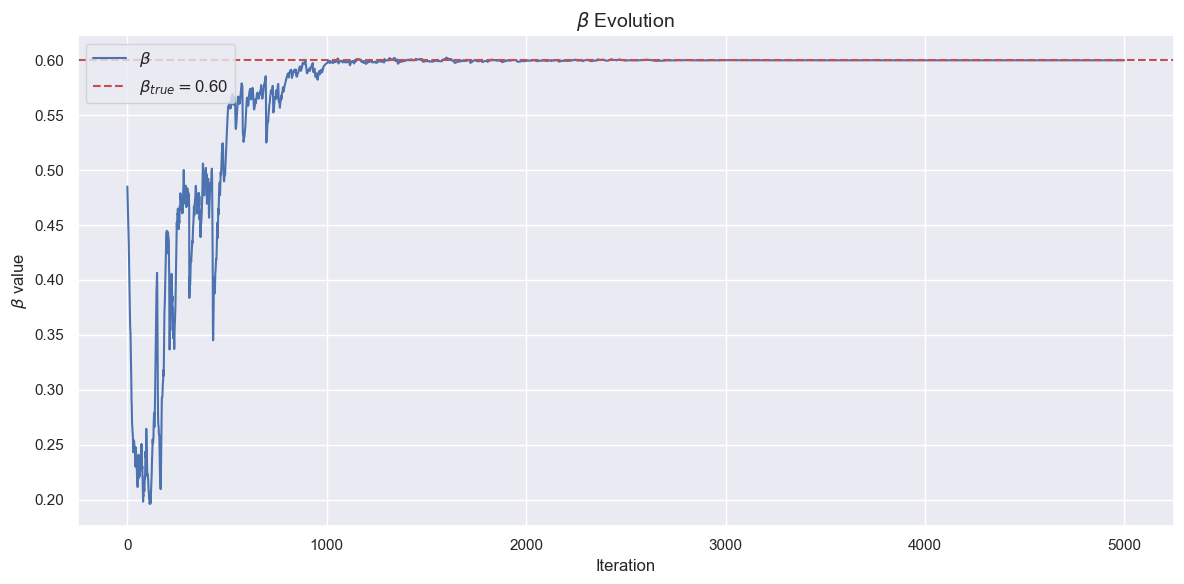

In [12]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=evolution_df['beta'], label='$\\beta$')
plt.axhline(
  y=beta_true,
  color='r',
  linestyle='--',
  label='$\\beta_{true} = $' + f'{beta_true:.2f}'
)

plt.title(f'$\\beta$ Evolution', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('$\\beta$ value', fontsize=12)

plt.legend(fontsize=12, loc='upper left')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f'{figures_dir}/beta_evolution_{timestamp}.png', dpi=300)

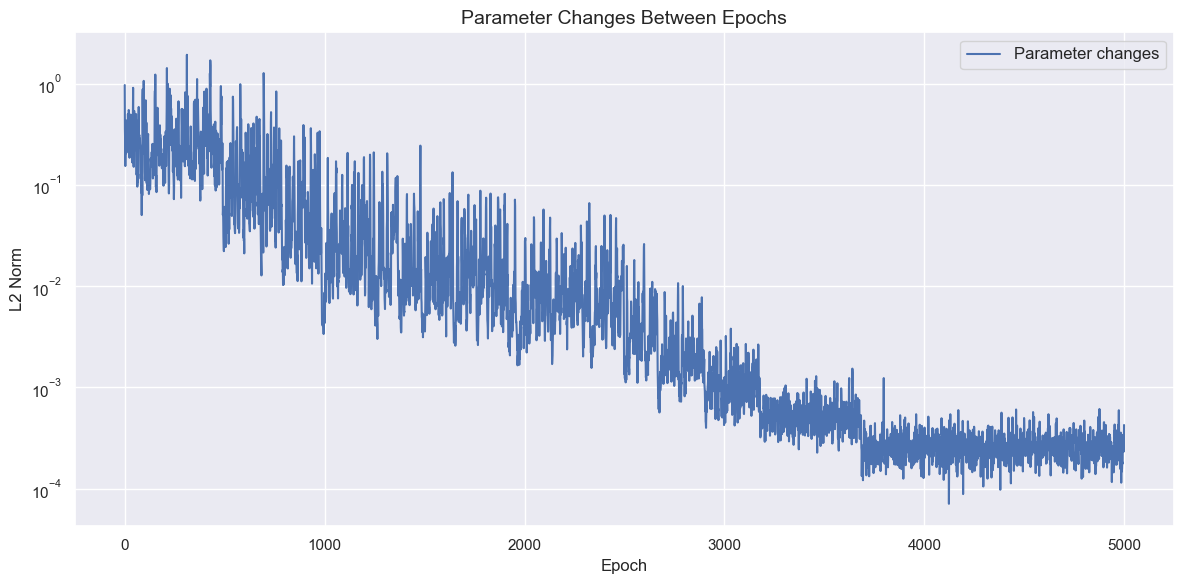

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=evolution_df['params'], label='Parameter changes')

plt.title('Parameter Changes Between Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('L2 Norm', fontsize=12)
plt.yscale('log')

plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig(f'{figures_dir}/param_changes_{timestamp}.png', dpi=300)

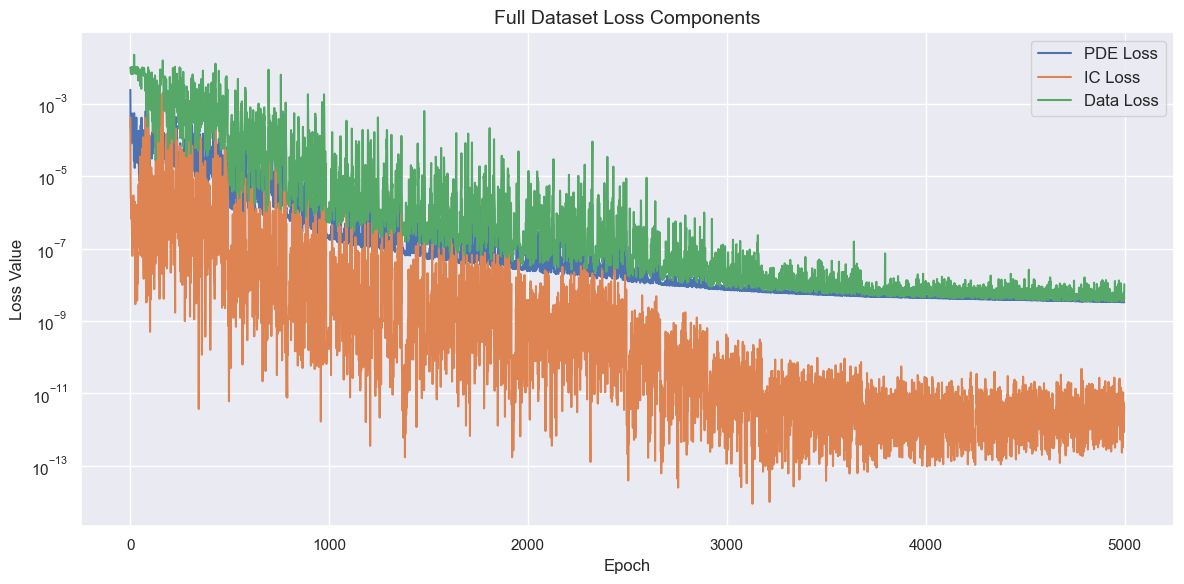

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=loss_df['L_pde'], label='PDE Loss')
sns.lineplot(data=loss_df['L_ic'], label='IC Loss')
sns.lineplot(data=loss_df['L_data'], label='Data Loss')

plt.title('Full Dataset Loss Components', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.yscale('log')

plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig(f'{figures_dir}/loss_history_{timestamp}.png', dpi=300)

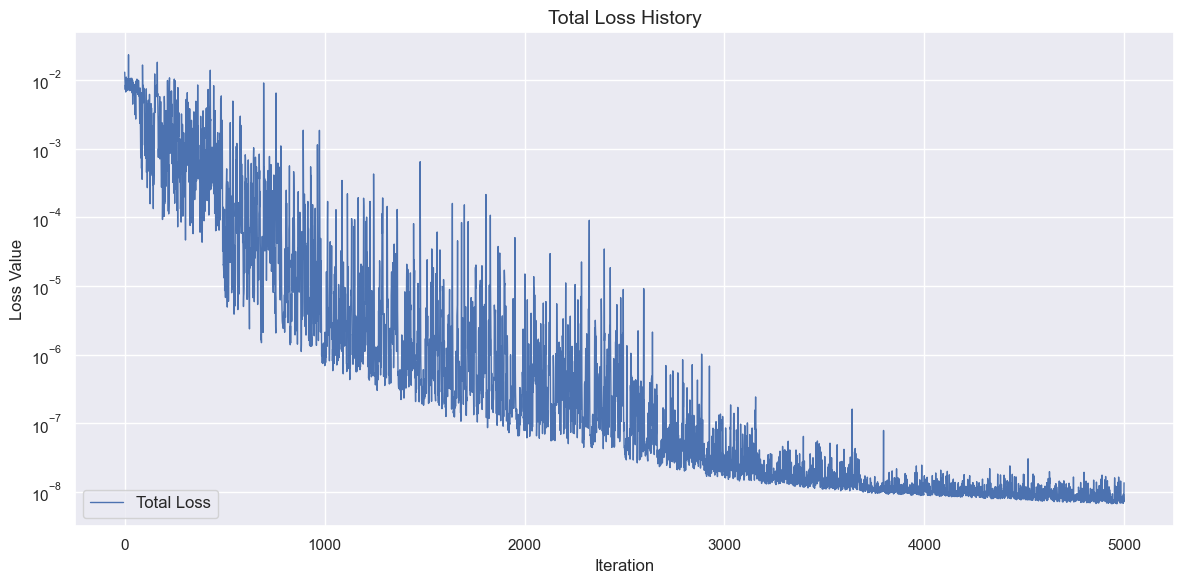

In [15]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=loss_df['L_total'], label='Total Loss', linewidth=1)

plt.title('Total Loss History', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.yscale('log')

plt.legend(fontsize=12, loc='lower left')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f'{figures_dir}/total_loss_history_{timestamp}.png', dpi=300)

In [24]:


def plot_avg_loss_history(loss_interval):
  # Initialize with placeholder values for the first loss_interval elements
  avg_loss_history = [np.inf] * loss_interval

  # Calculate the first SMMA value (simple average of first window)
  first_smma = np.mean(loss_df['L_total'][:loss_interval])
  avg_loss_history.append(first_smma)

  # Apply SMMA formula for the remaining data points
  for i in range(loss_interval + 1, len(loss_df)):
    current_value = loss_df['L_total'][i]
    previous_smma = avg_loss_history[-1]

    # SMMA formula: (previous_smma * (n-1) + current_value) / n
    current_smma = (previous_smma * (
        loss_interval - 1) + current_value) / loss_interval
    avg_loss_history.append(current_smma)

  plt.figure(figsize=(12, 6))

  sns.lineplot(data=loss_df['L_total'], label='Total Loss', linewidth=1)
  sns.lineplot(data=avg_loss_history, label='Average Loss', linewidth=1.5)

  plt.title('Average Loss History', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Loss Value', fontsize=12)
  plt.yscale('log')

  plt.legend(fontsize=12, loc='lower right')

  plt.tight_layout()

  plt.show()

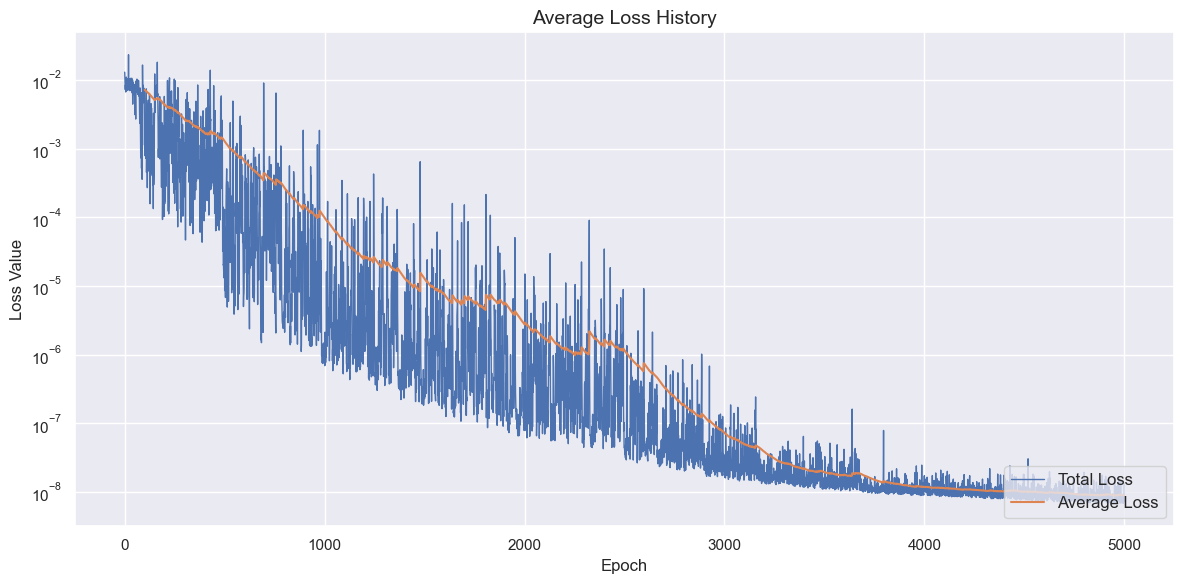

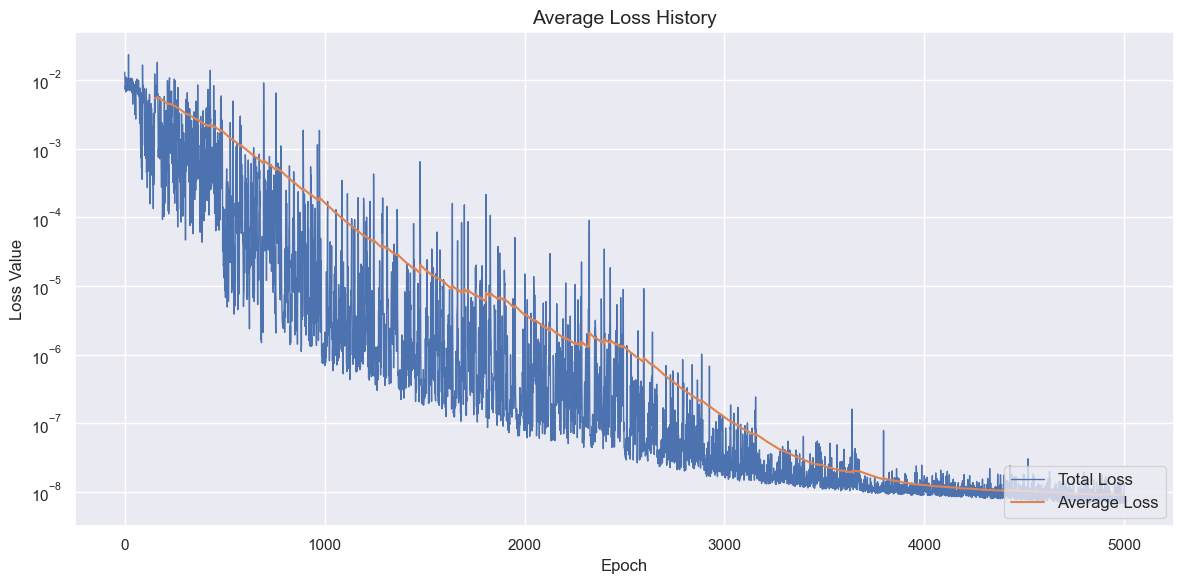

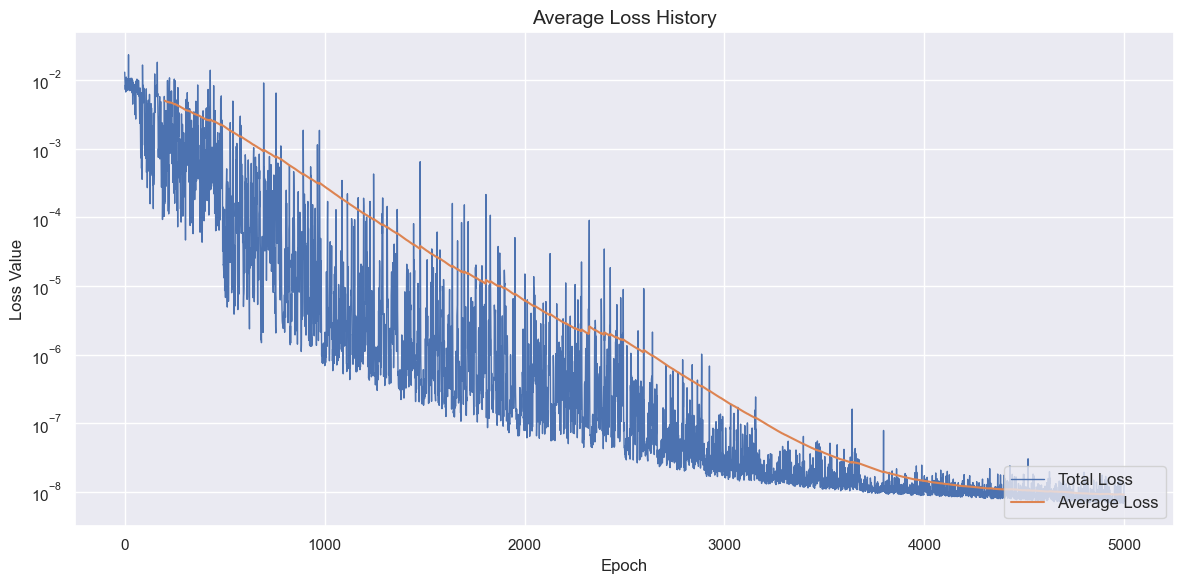

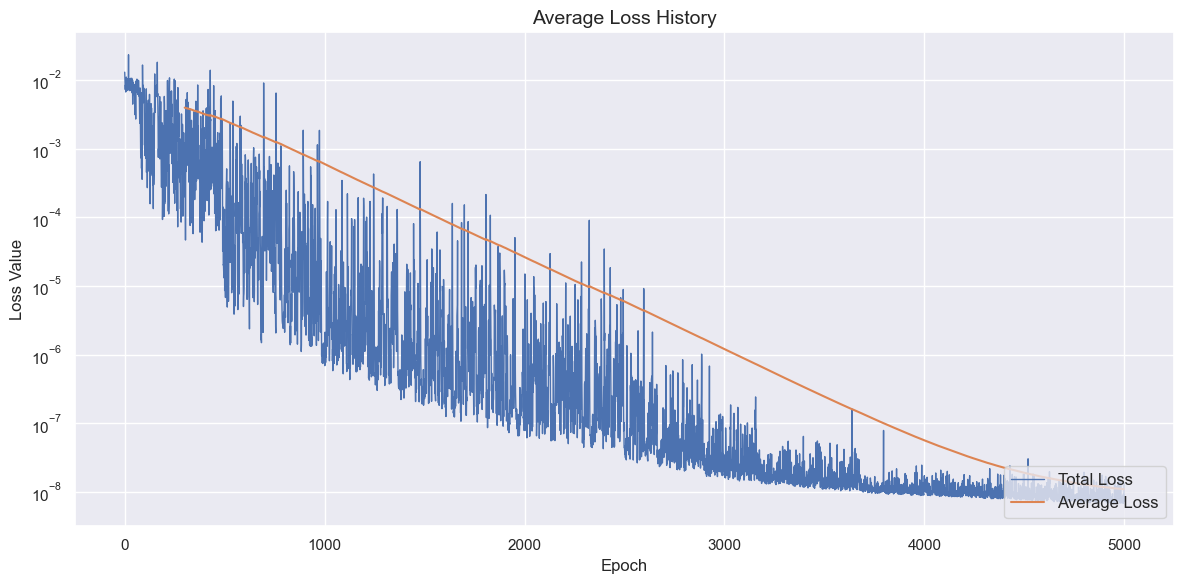

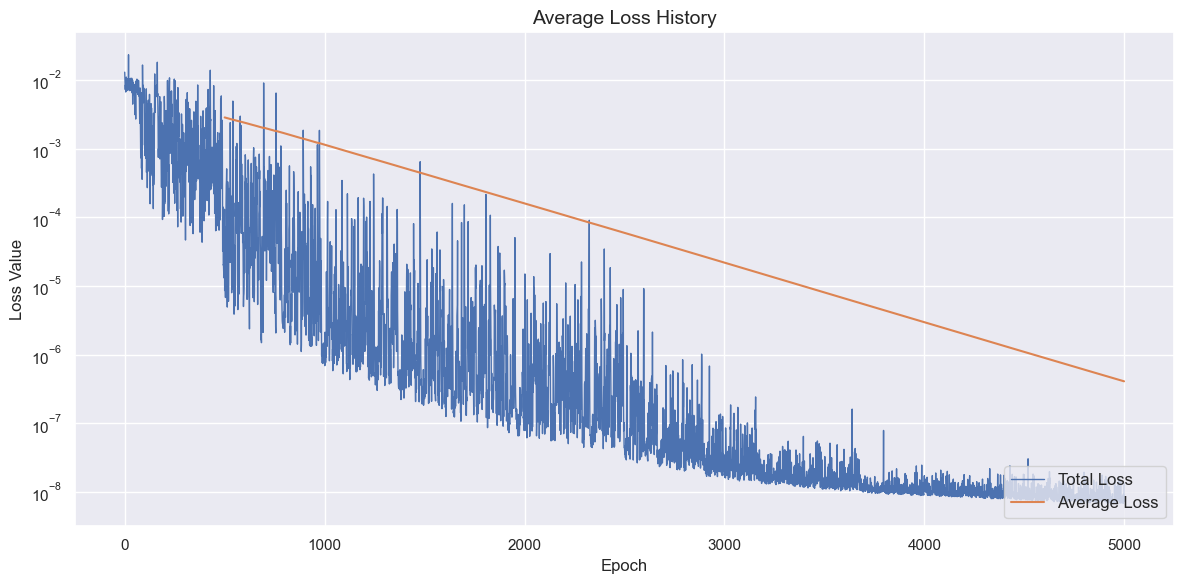

In [25]:
plot_avg_loss_history(100)
plot_avg_loss_history(150)
plot_avg_loss_history(200)
plot_avg_loss_history(300)
plot_avg_loss_history(500)

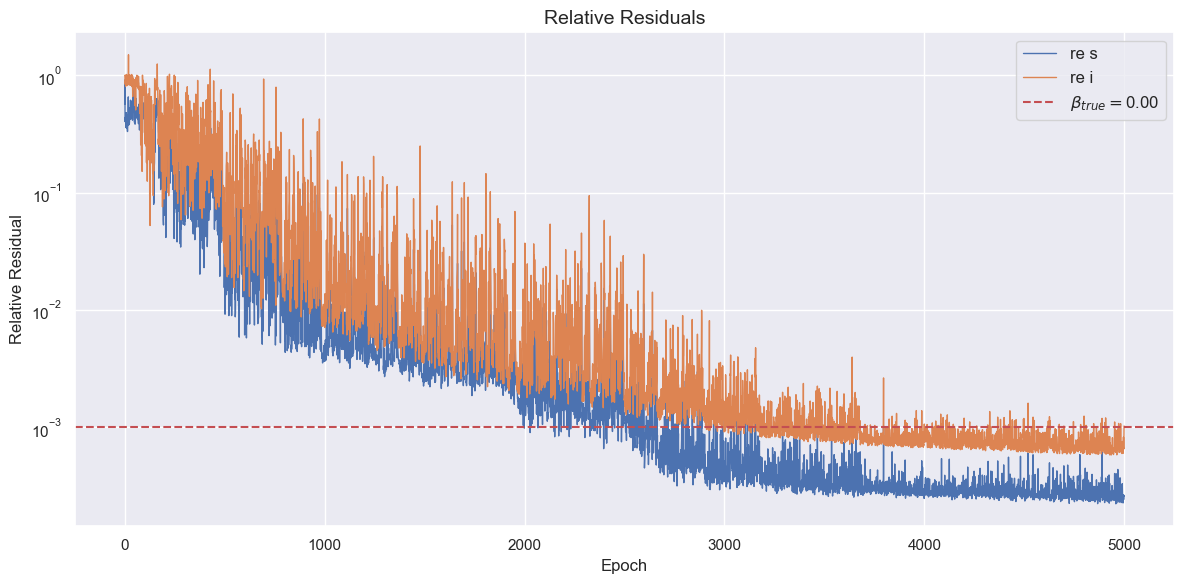

In [153]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=evolution_df["re_s"], label='re s', linewidth=1)
sns.lineplot(data=evolution_df["re_i"], label='re i', linewidth=1)
# horizontal line on 10-3
plt.axhline(
  y=1e-3,
  color='r',
  linestyle='--',
  label='$\\beta_{true} = $' + f'{1e-3:.2f}'
)

plt.title("Relative Residuals", fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Relative Residual', fontsize=12)
plt.yscale('log')

plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()

plt.savefig(f'{figures_dir}/re_res_history_{timestamp}.png', dpi=300)

In [146]:
def mse(pred, true):
  """Calculate Mean Squared Error between predicted and true values."""
  return np.mean((pred - true) ** 2)


def re(pred, true):
  """Calculate Relative Error between predicted and true values."""
  return np.linalg.norm(true - pred, 2) / np.linalg.norm(true, 2)


def mape(pred, true):
  """Calculate Mean Absolute Percentage Error between predicted and true values."""
  return mean_absolute_percentage_error(true, pred)


compartments = ["S", "I", "R"]
pred_arrays = [s_pred, i_pred, r_pred]
true_arrays = [s_true, i_true, r_true]

mse_values = [
  f"{mse(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
re_values = [
  f"{re(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
mape_values = [
  f"{mape(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]

errors = pd.DataFrame(
  {
    "Compartment": compartments,
    "MSE":         mse_values,
    "MAPE (%)":    mape_values,
    "RE":          re_values,
  }
)

display(HTML(errors.to_html(index=False)))

Compartment,MSE,MAPE (%),RE
S,3.13e-08,1.41e-03,2.60e-04
I,1.07e-08,7.73e+00,1.03e-03
R,3.99e-08,1.38e+08,3.33e-04


In [147]:
beta_error = abs(beta_pred - beta_true)
beta_error_percent = beta_error / beta_true * 100

beta_errors = pd.DataFrame(
  {
    "Parameter":          ["β"],
    "Predicted Value":    [f"{beta_pred:.4f}"],
    "True Value":         [f"{beta_true:.4f}"],
    "Absolute Error":     [f"{beta_error:.2e}"],
    "Relative Error (%)": [f"{beta_error_percent:.2f}%"],
  }
)

display(HTML(beta_errors.to_html(index=False)))

Parameter,Predicted Value,True Value,Absolute Error,Relative Error (%)
β,0.6000,0.6000,3.41e-05,0.01%
